# JWST Implementing Detector Effects in Simulations

Experience and analyses during JWST Cycle 1 showed that various detector systematics were the largest driver of systematic differences between actual measured PSFs and simulations. Physically, the result is that some photo-electron signals are measured in different pixels than the incident photon hit, acting to blur PSFs slightly. WebbPSF was originally designed as an optics-only simulation, leaving it up to users to optionally use other codes to model detector non-ideal behaviors. 

<div class="alert alert-block alert-info">

To make simulated PSFs a closer match to data "right out of the box", WebbPSF as of release 1.2 includes  simplified models to add significant detector effects into simulated PSFs for NIRCam, NIRISS, and MIRI. 
</div>

These effects come in two flavours:
 1.  Interpixel capacitance (IPC, for NIRCam, NIRISS, and MIRI) and Post-pixel coupling (PPC, NIRCam only), via convolution kernels measured from flight and ground-testing data.
 2. Charge diffusion, via a simple ad hoc Gaussian convolution, with parameters tuned to match in-flight empirical PSFs for NIRCam, NIRISS, and MIRI. 

### Detector physics is complicated. 

Please note that these are *simplified* models of extremely complex detector physics and nonlinearity. 
The true physical behavior is more complex, and includes for instance illumination- and time-dependent variations often referred to as the "brighter-fatter effect". See for instance [Plazas et al. 2018](https://iopscience.iop.org/article/10.1088/1538-3873/aab820/meta), [Argyriou et al. 2023](https://ui.adsabs.harvard.edu/abs/2023arXiv230313517A/abstract). Detector physics modeling at that level is outside of the scope of WebbPSF. 
The included models of detector effects represent a first pass effort, and we expect will continue to be refined in fidelity over time.  



In [8]:
import webbpsf 
import numpy as np
import matplotlib.pyplot as plt

## Understanding output PSF products, and where to find the PSFs with detector effects

Recall that PSF outputs are returned as FITS HDULists with multiple extensions, for instance like: 

```
Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format            # Comment
  0  OVERSAMP      1 PrimaryHDU     104   (236, 236)   float64           # Ideal PSF, oversampled
  1  DET_SAMP      1 ImageHDU       106   (59, 59)   float64             # Ideal PSF, detector-sampled
  2  OVERDIST      1 ImageHDU       153   (236, 236)   float64           # With distortions, oversampled
  3  DET_DIST      1 ImageHDU       159   (59, 59)   float64             # With distortions, detector-sampled
```


The first two extensions give the "ideal" diffractive PSF (i.e. "photons only"). Geometric distortion effects and detector charge transfer effects are then added to create the last two extensions, named OVERDIST and DET_DIST. The charge diffusion kernel, a continuous effect, is present in both of those; the IPC effect, which is inherently a quantized effect acting on physical detector pixels, is applied after downsampling to detector resolution and is thus only present in the DET_DIST extension by default. 

<div class="alert alert-block alert-info">

**To make use of the detector-effects-included PSFs, in general use the DET_DIST (last) FITS extension of the output PSF FITS file.**
    
</div>

## NIRCam Simulation with detector effects: charge diffusion and IPC+PPC 

These effects are now included in simulated PSFs by default. 

In [5]:
nrc = webbpsf.NIRCam()
nrc.filter = 'F212N'
fov_pixels = 59
single_webbpsf_nircam = nrc.calc_psf(fov_pixels=fov_pixels)

We use a simple Gaussian convolution as a proxy of charge diffusion. The value of sigma is parameterized as arcseconds for convenience. The current values of sigma are placeholders that can be change in order to better fit observations. You can access the detector charge diffusion default values from webbpsf.constants

In [9]:
print(webbpsf.constants.INSTRUMENT_DETECTOR_CHARGE_DIFFUSION_DEFAULT_PARAMETERS)

{'NIRCAM_SW': 0.0062, 'NIRCAM_LW': 0.018, 'NIRISS': 0.0202, 'FGS': 0.07, 'NIRSPEC': 0.036, 'MIRI': 0.001}


## NIRCam Simulation without detector effects

For comparison, let's calculate a PSF with these effects disabled. 

Detector effects can be deactivated via the 'charge_diffusion_sigma' and 'add_ipc' options. Similarly, the 'charge_diffusion_sigma' option can be use to vary sigma to better fit observations. 

In [10]:
nrc = webbpsf.NIRCam()
nrc.filter = 'F212N'
nrc.options['charge_diffusion_sigma'] = 0
nrc.options['add_ipc'] = False
fov_pixels = 59
single_webbpsf_nircam_no_effects = nrc.calc_psf(fov_pixels=fov_pixels)


## Comparison between simulations with and without detector effects

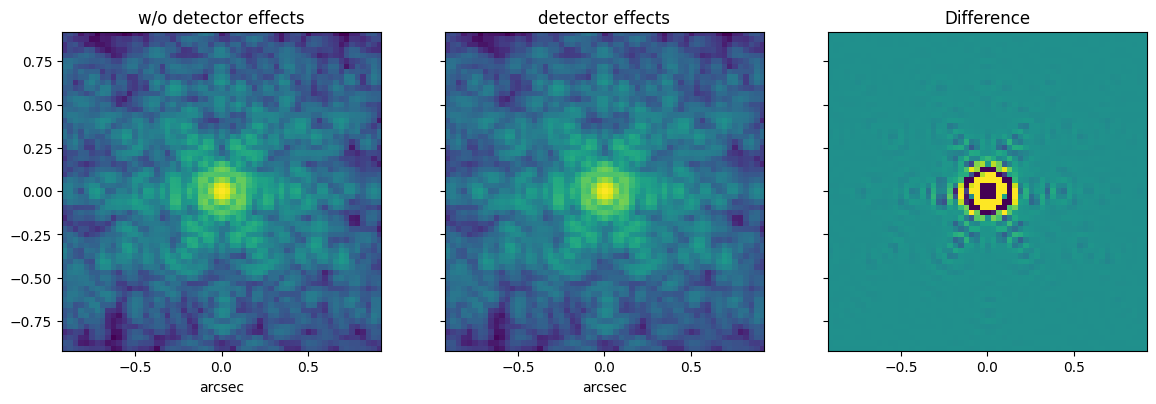

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(14,7), sharey=True)

webbpsf.display_psf(single_webbpsf_nircam_no_effects, ext = 3, title = 'w/o detector effects', cmap = 'viridis', ax = ax1, colorbar=False )
webbpsf.display_psf(single_webbpsf_nircam, ext = 3,  title = 'detector effects', cmap = 'viridis', ax = ax2, colorbar=False )
webbpsf.display_psf_difference(single_webbpsf_nircam,single_webbpsf_nircam_no_effects, ext1 = 3, ext2 = 3, title = 'Difference', cmap = 'viridis', ax = ax3, colorbar=False )


The above shows a comparison between simulations with and without detector effects. From the difference between simulations, it shows that our charge diffusion term is the leading term by broadening the simulated PSF.

## Comparison with observations of empirical PSFs
We are going to compare NIRISS observations and webbpsf simulations with and without detector effects. 
For this we are using the set of effective point-spread function (ePSF) presented in [Libralato et al 2023 ApJ 950 101](https://ui.adsabs.harvard.edu/abs/2023ApJ...950..101L/abstract). 

Let's define a simple function to meassure FWHM for our set of observed and simulated PSFs. Note that we could also use webbpsf.measure_fwhm to acomplish the same result. 

In [160]:
def measure_fwhm(array):
    """Fit a Gaussian2D model to a PSF and return the fitted PSF
    the FWHM is x and y can be found with fitted_psf.x_fwhm, fitted_psf.y_fwhm

    Parameters
    ----------
    array : numpy.ndarray
        Array containing PSF

    Returns
    -------
    x_fwhm : float
        FWHM in x direction in units of pixels

    y_fwhm : float
        FWHM in y direction in units of pixels
    """
    from astropy.modeling import models, fitting
    yp, xp = array.shape
    y, x, = np.mgrid[:yp, :xp]
    p_init = models.Gaussian2D(amplitude = array.max(), x_mean=xp*0.5,y_mean=yp*0.5)
    fit_p = fitting.LevMarLSQFitter()
    fitted_psf = fit_p(p_init, x, y, array)
    return fitted_psf


First, we simulate and calculate the FWHM for the PSFs without detector effects for all NIRISS filters. 

In [147]:
wave_arr = np.array([])
fwhm_fun_arr_no_effects = np.array([]) 
for filters in niriss.filter_list[:-1]:
    niriss = webbpsf.NIRISS()
    niriss.filter = filters
    niriss.options['charge_diffusion_sigma'] = 0
    niriss.options['add_ipc'] = False
    fov_pixels = 25
    print('Starting {} simulation without detector effects'.format(filters))
    single_webbpsf_niriss_no_effects = niriss.calc_psf(fov_pixels=fov_pixels)
    wave_arr = np.append(wave_arr, single_webbpsf_niriss_no_effects[3].header['WAVELEN'])
    fitted_psf = measure_fwhm(single_webbpsf_niriss_no_effects[3].data)
    fwhm_fun_arr_no_effects = np.append(fwhm_fun_arr_no_effects,np.sqrt(fitted_psf.x_fwhm * fitted_psf.y_fwhm)*niriss.pixelscale)
    

Starting F090W simulation without detector effects
Starting F115W simulation without detector effects
Starting F140M simulation without detector effects
Starting F150W simulation without detector effects
Starting F158M simulation without detector effects
Starting F200W simulation without detector effects
Starting F277W simulation without detector effects
Starting F356W simulation without detector effects
Starting F380M simulation without detector effects
Starting F430M simulation without detector effects
Starting F444W simulation without detector effects
Starting F480M simulation without detector effects


Then, we perform the simulation and FWHM calculation for the PSFs with the inclusion of detector effects

In [150]:
wave_arr = np.array([])
fwhm_fun_arr = np.array([]) 
for filters in niriss.filter_list[:-1]:
    niriss = webbpsf.NIRISS()
    niriss.filter = filters
    fov_pixels = 25
    print('Starting {} simulation with detector effects'.format(filters))
    single_webbpsf_niriss = niriss.calc_psf(fov_pixels=fov_pixels)
    wave_arr = np.append(wave_arr, single_webbpsf_niriss[3].header['WAVELEN'])
    fitted_psf = measure_fwhm(single_webbpsf_niriss[3].data)
    fwhm_fun_arr = np.append(fwhm_fun_arr,np.sqrt(fitted_psf.x_fwhm * fitted_psf.y_fwhm)*niriss.pixelscale)
        

Starting F090W simulation with detector effects
Starting F115W simulation with detector effects
Starting F140M simulation with detector effects
Starting F150W simulation with detector effects
Starting F158M simulation with detector effects
Starting F200W simulation with detector effects
Starting F277W simulation with detector effects
Starting F356W simulation with detector effects
Starting F380M simulation with detector effects
Starting F430M simulation with detector effects
Starting F444W simulation with detector effects
Starting F480M simulation with detector effects


Let's take a look at the observed ePSF for NIRISS. For this you will need to download all the NIRISS ePSFs into a local folder. The NIRISS ePSFs from Libralato et al [may be retrieved from this web site](https://www.stsci.edu/~jayander/JWST1PASS/LIB/PSFs/STDPSFs/NIRISS/). 

In [143]:
from glob import glob
stdpsf = (glob('STDPSF_NIRISS/*fits'))
stdpsf.sort()

Note the ePSFs are 4x oversample, corresponding to a radial distance of 12.5 real NIRISS pixels. Conveniently this is the same oversampling factor that webbpsf uses by default. 

In [144]:
from astropy.io import fits
from scipy import ndimage
fwhm_fun_arr_epsf = np.array([])

for fn in stdpsf:
    hd = fits.open(fn)
    eps_data = ndimage.zoom(hd[0].data[12],0.25) # the ePSF is binned down to detector-sampled 
    fitted_psf_epsf = measure_fwhm(eps_data)
    fwhm_fun_arr_epsf = np.append(fwhm_fun_arr_epsf,np.sqrt(fitted_psf_epsf.x_fwhm * fitted_psf_epsf.y_fwhm)*niriss.pixelscale)
   

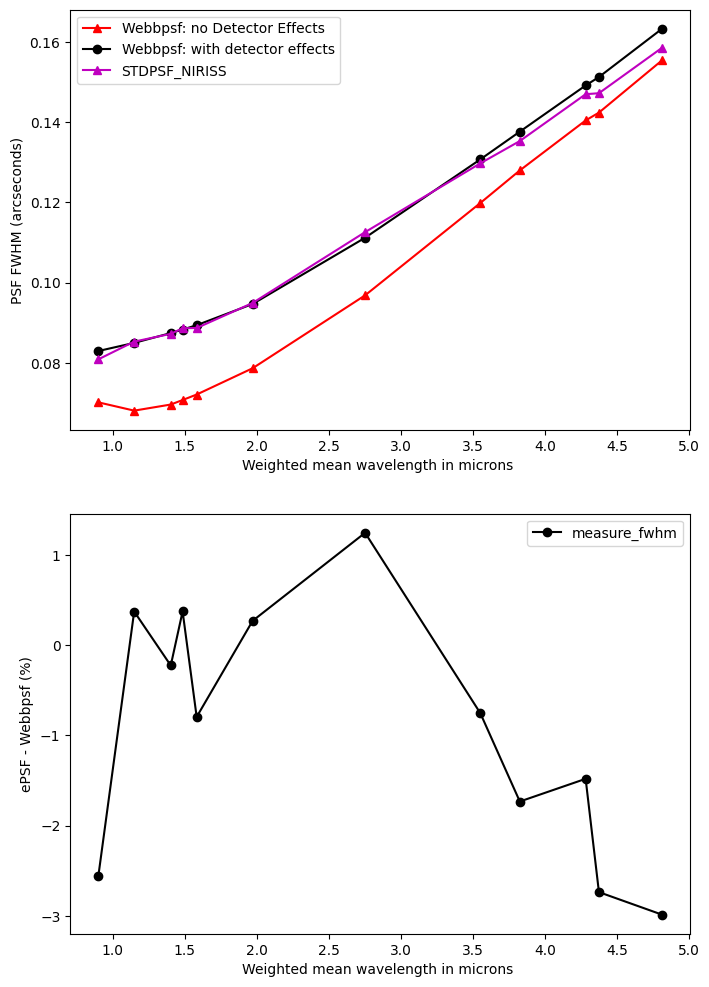

In [151]:
plt.figure(figsize = [8,12])
plt.subplot(2,1,1)
plt.plot(wave_arr*1e6,fwhm_fun_arr_no_effects, 'r^-' , label = 'Webbpsf: no Detector Effects')
plt.plot(wave_arr*1e6,fwhm_fun_arr, 'ko-', label = 'Webbpsf: with detector effects' )
plt.plot(wave_arr*1e6,fwhm_fun_arr_epsf, 'm^-', label = 'STDPSF_NIRISS' )
plt.xlabel('Weighted mean wavelength in microns ')
plt.ylabel('PSF FWHM (arcseconds)')
plt.legend(loc = 2)
plt.subplot(2,1,2)
plt.plot(wave_arr*1e6,(fwhm_fun_arr_epsf  - fwhm_fun_arr)*100/fwhm_fun_arr_epsf, 'ko-', label = 'measure_fwhm' )
plt.xlabel('Weighted mean wavelength in microns ')
plt.ylabel('ePSF - Webbpsf (%)')
plt.legend(loc = 0)

From the comparison above it is clear that webbpsf simulations with detector effects are a good match to observations. Note that our basic implementation for charge diffusion is wavelength-independent. However, it is clear that at longer wavelengths we should adjust sigma_charge_difussion to obtain a better fit.

## Comparison to measured PSFs for other instruments

Comparisons with preliminary (unpublished, but to be published soon) ePSFs for NIRCam and MIRI shows similarly good matches of webbpsf 1.2 outputs to the measured ePSFs. 

This comparison includes  NIRCam (all detectors in SW and LW in many filters), and MIRI (all imaging filters). 

These tests do provide evidence for a small dependence of the charge diffusion length scale on wavelength or filter, as expected from theory, and differences in detail between the NIRCam detectors. The adopted parameters currently in webbpsf as defaults were selected as to achieve well-balanced average fits over the full focal plane and all filters for each instrument. 

You may find that adjusting the `charge_diffusion_sigma` parameter slightly up or down will allow more precise fits to your particular science data. The WebbPSF team welcomes feedback about what parameters work well for particular datasets, as input into ongoing work to further refine these models. 

## What about NIRSpec? Or FGS? 

Implementation of improved PSF models is prioritizing the imaging instruments first. 

Note that IPC effects are yet to be implemented in NIRSpec and FGS simulations, pending available flight calibrations to precisely quantify the IPC effects in those detectors.  




## Detector effects in effective PSF grids

Detector effects are included in effective PSF grids calculated with the `psf_grid` function, too. No special effort or function call parameters are needed for this; it's automatic. 

In particular the `psf_grid` calculation now includes an adjusted implementation of the IPC effect which enables self-consistently including the IPC effect in reconstructed ePSFs on subpixel scales. 
